In [1]:
import tensorflow as tf
import os
import sys
from tensorflow import keras
import sklearn
from tensorflow.python.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import cv2
from cv2 import Canny
from skimage.morphology import dilation, erosion, white_tophat, skeletonize
from skimage.morphology import disk 
from skimage import transform
from sklearn.svm import SVC

In [2]:
class_names = ['MALIGNANTMASSES', 'CALC', 'BENIGNMASSES', 'NORM']
class_names_label = {class_names:i for i, class_names in enumerate(class_names)}
print(class_names_label)

IMAGE_SIZE = (224, 224, 3)

def load_data():
    main_directory = r"C:\Users\hp\Documents\CursoML\processed"
    CATEGORY = ["Training", "Testing"]
    
    output = []
    
    for category in CATEGORY: 
        path = os.path.join(main_directory, category)
        print(path)
        
        images = []
        labels = []
        
       # print("Loading {}".format(category))
        
        for folder in os.listdir(path):
            print(folder)
            label = list(class_names_label.values())[int(folder)-1]
            
            for file in os.listdir(os.path.join(path, folder)):
                img_path = os.path.join(os.path.join(path, folder), file)
                
                image = io.imread(img_path, as_gray=True, plugin='matplotlib')
                image = transform.resize(image, IMAGE_SIZE)
                
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')
        
        output.append((images, labels))
        
    return output

{'MALIGNANTMASSES': 0, 'CALC': 1, 'BENIGNMASSES': 2, 'NORM': 3}


In [3]:
(train_images, train_labels), (test_images, test_labels) = load_data() 


C:\Users\hp\Documents\CursoML\processed\Training
1
2
3
4
C:\Users\hp\Documents\CursoML\processed\Testing
1
2
3
4


In [4]:
len(train_images) #cantidad de imagenes de entrenamiento

827

In [5]:
len(class_names)

4

<function matplotlib.pyplot.show(close=None, block=None)>

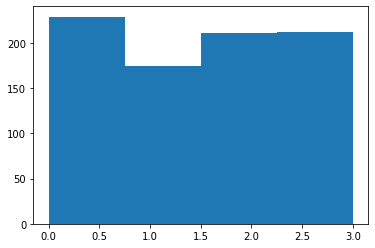

In [61]:
#histograma de frecuencia de las etiquetas
plt.hist(train_labels, len(set(train_labels)))
plt.show

In [62]:
import random
rand_breast = random.sample(range(0, len(train_images)), 6)
rand_breast

[343, 384, 95, 651, 87, 703]

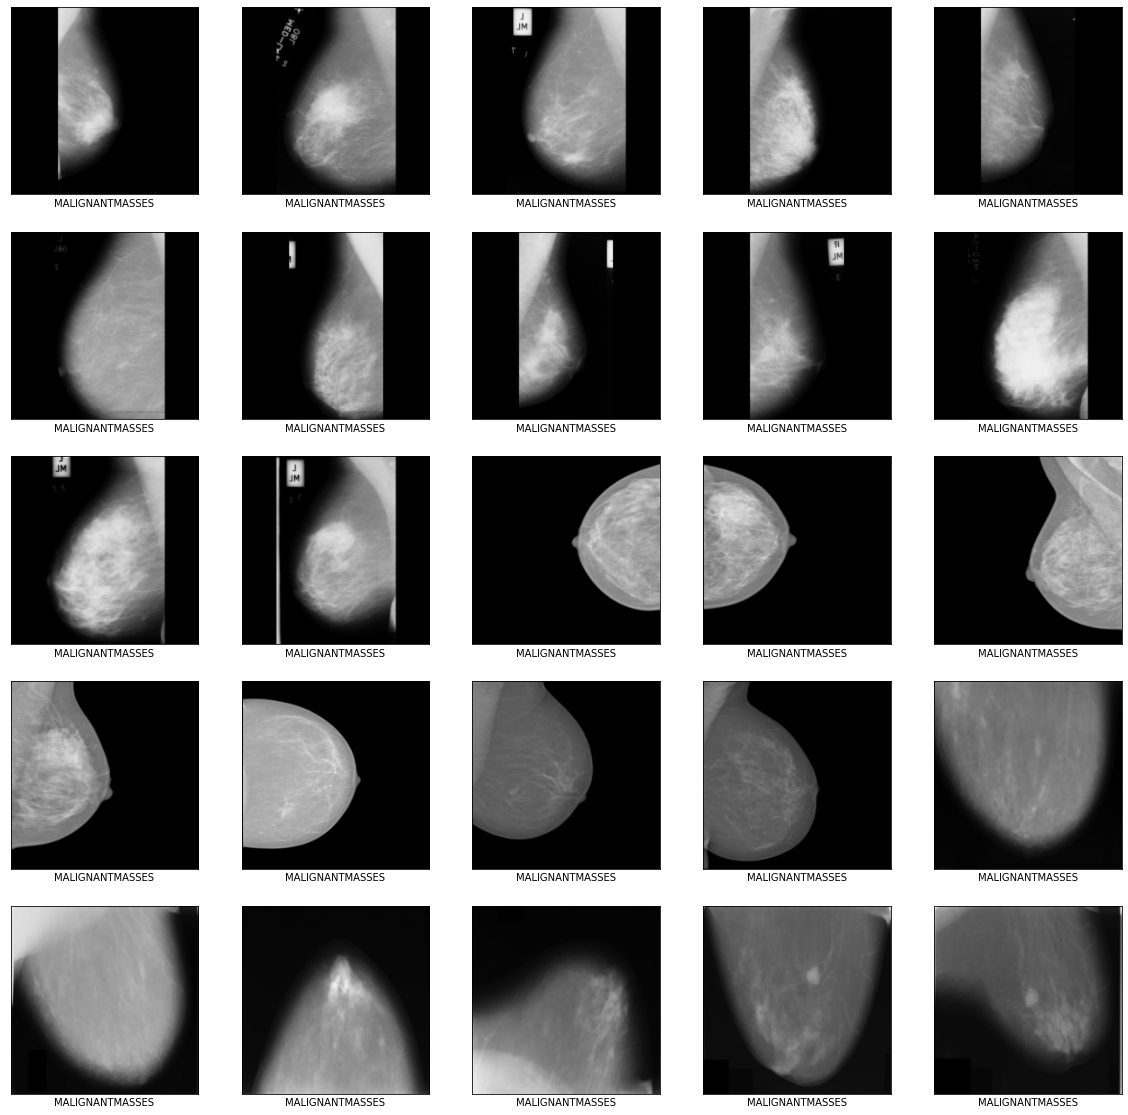

In [63]:
def display_examples(class_names, images, labels):
    figsize = (20,20)
    fig = plt.figure(figsize = figsize)
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap="gray")
        plt.xlabel(class_names[labels[i]])
    plt.show()
display_examples(class_names, train_images, train_labels)

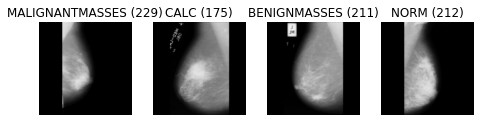

In [64]:
unique_labels_numerico = set(train_labels)
plt.figure(figsize=(16,16))
i = 1
for label_numerico in unique_labels_numerico:
    temp_im = train_images[list(class_names_label).index(class_names[label_numerico])]
    plt.subplot(8,8, i)
    plt.axis("off")
    plt.title("{0} ({1})".format(class_names[label_numerico], list(train_labels).count(label_numerico)))
    i=i+1
    plt.imshow(temp_im, cmap="gray")
plt.show()

## Modelo de red neuronal

In [6]:
import keras
#from keras.utils import to_categorical
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import batch_normalization
from keras.layers.advanced_activations import LeakyReLU

#CREAR EL MODELO

cancer_model = tf.keras.models.Sequential() #pila de capas

cancer_model.add(tf.keras.layers.Conv2D(128, kernel_size=(5,5), activation='linear', padding='same', input_shape=(224,224,3))) #capa de convolucion
cancer_model.add(LeakyReLU(alpha=0.1))
cancer_model.add(tf.keras.layers.MaxPooling2D((2, 2),padding='same')) #agrupacion
cancer_model.add(tf.keras.layers.Conv2D(128, kernel_size=(5,5), activation = 'relu'))
cancer_model.add(LeakyReLU(alpha=0.1))
cancer_model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))
cancer_model.add(tf.keras.layers.Conv2D(128, (5, 5), activation='linear', padding='same'))
cancer_model.add(LeakyReLU(alpha=0.1))
cancer_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
cancer_model.add(tf.keras.layers.Flatten())
cancer_model.add(tf.keras.layers.Dense(128, activation='linear'))
cancer_model.add(LeakyReLU(alpha=0.1))
cancer_model.add(tf.keras.layers.Dense(4, activation='softmax')) #capa softmax para clasificacion

cancer_model.summary()

cancer_model.compile(optimizer="adam",
                     loss=keras.losses.sparse_categorical_crossentropy,
                     metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 128)     9728      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 128)     409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 108, 108, 128)     0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                    

In [ ]:
#Entrenamiento
INIT = 1e-3
epochs = 12
batch_size = 128 #numero de muestras por actualizacion 
cancer_train = cancer_model.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs)

Epoch 1/12


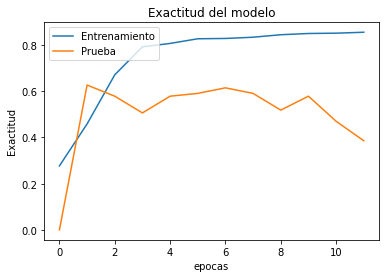

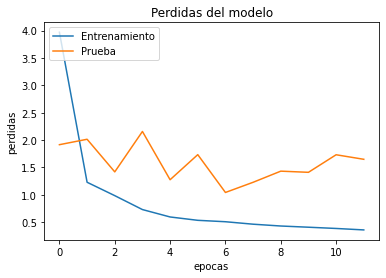

In [86]:
plt.plot(cancer_train.history['accuracy'])
plt.plot(cancer_train.history['val_accuracy'])
plt.title('Exactitud del modelo')
plt.ylabel('Exactitud')
plt.xlabel('epocas')
plt.legend(['Entrenamiento', 'Prueba'], loc='upper left')
plt.show()

plt.plot(cancer_train.history['loss'])
plt.plot(cancer_train.history['val_loss'])
plt.title('Perdidas del modelo')
plt.ylabel('perdidas')
plt.xlabel('epocas')
plt.legend(['Entrenamiento', 'Prueba'], loc='upper left')
plt.show()

In [78]:
print(cancer_train.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [115]:
test_eval = cancer_model.evaluate(test_images, test_labels)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

10/10 [==============================] - 69s 5s/step - loss: 0.6928 - accuracy: 0.8301
Test loss: 0.6927545666694641
Test accuracy: 0.8301281929016113


In [121]:
predictions = cancer_model.predict(test_images)
pred_labels = np.argmax(predictions, axis = 1)
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        96
           1       0.69      0.86      0.77        71
           2       1.00      0.75      0.86        83
           3       0.64      0.74      0.69        62

    accuracy                           0.83       312
   macro avg       0.83      0.82      0.82       312
weighted avg       0.86      0.83      0.84       312



In [120]:
cancer_model.save("model_tesis.h5")

In [6]:
#vgg16
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

model = VGG16(weights = 'imagenet', include_top = False)
model = Model(inputs=model.inputs, outputs= model.layers[-5].output)

In [7]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

In [8]:
from keras.layers import Input, Dense, Conv2D, Activation, MaxPooling2D, Flatten

model2 = VGG16(weights = 'imagenet', include_top = False)

input_shape = model2.layers[-4].get_input_shape_at(0)
layer_input = Input(shape = (14, 14, 512))

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(64, (3,3), activation = 'relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = Dense(4, activation = 'softmax')(x)

#new model
new_model = Model(layer_input, x)

In [9]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
history = new_model.fit(train_features, train_labels, batch_size = 128, epochs = 10)

Epoch 1/10
7/7 [==============================] - 49s 7s/step - loss: 1.8525 - accuracy: 0.3652
Epoch 2/10
7/7 [==============================] - 45s 6s/step - loss: 0.8158 - accuracy: 0.7074
Epoch 3/10
7/7 [==============================] - 46s 6s/step - loss: 0.6933 - accuracy: 0.7424
Epoch 4/10
7/7 [==============================] - 46s 6s/step - loss: 0.6072 - accuracy: 0.7666
Epoch 5/10
7/7 [==============================] - 45s 6s/step - loss: 0.5437 - accuracy: 0.8114
Epoch 6/10
7/7 [==============================] - 45s 6s/step - loss: 0.5163 - accuracy: 0.8114
Epoch 7/10
7/7 [==============================] - 45s 6s/step - loss: 0.5123 - accuracy: 0.8041
Epoch 8/10
7/7 [==============================] - 46s 6s/step - loss: 0.4820 - accuracy: 0.8186
Epoch 9/10
7/7 [==============================] - 46s 6s/step - loss: 0.4539 - accuracy: 0.8368
Epoch 10/10
7/7 [==============================] - 48s 7s/step - loss: 0.4482 - accuracy: 0.8235


In [11]:
from sklearn.metrics import accuracy_score

predictions = new_model.predict(test_features)
pred_labels =np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))


Accuracy : 0.8301282051282052


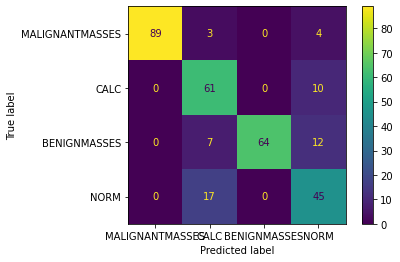

In [13]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_labels, pred_labels),
                              display_labels=class_names)
disp.plot()
plt.show()

In [14]:
precision_score(test_labels, pred_labels, average='weighted')

0.8574092427525526

In [15]:
recall_score(test_labels, pred_labels, average='weighted')

0.8301282051282052

In [70]:
from keras.applications.vgg16 import VGG16
# load model
model = VGG16()
# summarize the model
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     